## <div align="center">Predicting ICU Survival Rate within 30 Days Leveraging NLP-based Machine Learning Pipelines</div>

##### <div align="right">Capstone Project for Data Scientist Nanodegree on [Udacity](https://www.udacity.com/)</div>
##### <div align="right">Author: [Ronghui Zhou](https://www.linkedin.com/in/ronghuizhou/); March 30, 2020</div>
                                                                        
    1. Introduction
    2. Patient Cohort & Data Preparation
    3. Exploratory Data Analysis
    4. Statistical Analysis & Hypothesis test
    5. Natural Language Processing based Machine Learning Pipelines
    6. Exploratory Data Analysis for Balanced Dataset
    7. Natural Language Processing based Machine Learning Pipelines: Balanced Dataset
    8. Model Evaluation & Optimization
    9. Conclusion & Perspective
    
    
[GitHub](https://github.com/RonghuiZhou/Predicting-ICU-Survival-Rate-Leveraging-NLP-based-Machine-Learning-Pipelines)  

[Medium](https://medium.com/@RonghuiZhou/icu-survival-rate-within-30-days-leveraging-natural-language-processing-a0d8fcaeecde)
    


### <div align="center">1. Introduction</div>

#### Project Overview

This project will outline how to select a patient cohort, clean the data for exploratory visualization and building a classification model to predict the mortality within 30 days after ICU admission, utilizing initial caregivers’ notes. 

#### Problem Statement
The goal is to identify potential high risk patients and try to predict the possibility of survival within 30 days after the ICU admission. If the chance is low, actions should be taken to intervene.

#### Data Set

https://mimic.physionet.org/


MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC is made available largely through the work of researchers at the MIT Laboratory for Computational Physiology and collaborating research groups.


    MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. 

Available at: http://www.nature.com/articles/sdata201635


#### Metrics

We will evaluate the performance of machine learning models based on accuracy and confusion matrix.

Classification report shows the metrics: precision, recall, f1-score, and support.


### <div align="center">2. Patient Cohort & Data Preparation</div>
#### Patient Cohort

In this project, ICU patients in the age range 18 to 100 will be selected. 

#### Database Setup: PostgreSQL

https://mimic.physionet.org/tutorials/install-mimic-locally-windows/

Installing MIMIC-III in a local Postgres database on Windows

Note that before proceeding with this guide you will need to:

    a. Download the MIMIC-III Clinical Database
    b. Extract the MIMIC-III Clinical Database as .csv files somewhere on your local computer
    c. Download the PostgreSQL scripts - only the files which end in .sql are required

Note: I tried to install gzip and 7-zip and added to the path, but didn't work. So I installed cygwin which worked for me.
https://cygwin.com/install.html

#### Import libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import getpass

%matplotlib inline
plt.style.use('ggplot')

#### Set up the connection to the PostgreSQL database

In [2]:
# information used to create a database connection
sqluser = 'postgres'
host = 'localhost'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database (pwd: whatever you specified when setting up the database)
con = psycopg2.connect(dbname=dbname, user=sqluser, host=host, 
                      password=getpass.getpass(prompt='Password:'.format(sqluser)))

# the below statement is prepended to queries to ensure they select from the right schema
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

Password:········


#### Check the tables in the database

In [3]:
# Get all table names in this database
query=\
"""
SELECT *
FROM pg_catalog.pg_tables
ORDER BY schemaname, tablename
"""
df = pd.read_sql_query(query, con)
df.head(10)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,information_schema,sql_features,postgres,None,False,False,False,False
1,information_schema,sql_implementation_info,postgres,None,False,False,False,False
2,information_schema,sql_languages,postgres,None,False,False,False,False
3,information_schema,sql_packages,postgres,None,False,False,False,False
4,information_schema,sql_parts,postgres,None,False,False,False,False
5,information_schema,sql_sizing,postgres,None,False,False,False,False
6,information_schema,sql_sizing_profiles,postgres,None,False,False,False,False
7,mimiciii,admissions,postgres,None,True,False,False,False
8,mimiciii,callout,postgres,None,True,False,False,False
9,mimiciii,caregivers,postgres,None,True,False,False,False


In [4]:
# list schemanames
df.schemaname.value_counts()

pg_catalog            63
mimiciii              43
information_schema     7
Name: schemaname, dtype: int64

In [5]:
# Get the mimiciii table names in the database, sort by tablename
query=\
"""
SELECT *
FROM pg_catalog.pg_tables
WHERE schemaname != 'pg_catalog'
AND schemaname != 'information_schema'
ORDER BY tablename
"""
df = pd.read_sql_query(query, con)
df

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,mimiciii,admissions,postgres,None,True,False,False,False
1,mimiciii,callout,postgres,None,True,False,False,False
2,mimiciii,caregivers,postgres,None,True,False,False,False
3,mimiciii,chartevents,postgres,None,True,False,True,False
4,mimiciii,chartevents_1,postgres,None,False,False,False,False
5,mimiciii,chartevents_10,postgres,None,False,False,False,False
6,mimiciii,chartevents_11,postgres,None,False,False,False,False
7,mimiciii,chartevents_12,postgres,None,False,False,False,False
8,mimiciii,chartevents_13,postgres,None,False,False,False,False
9,mimiciii,chartevents_14,postgres,None,False,False,False,False


#### Check tables used in the project:
a. icustays
b. admissions
c. patients
d. noteevents

In [6]:
# check icustays table

query = \
"""
SELECT *
FROM icustays
ORDER by subject_id, hadm_id, icustay_id
LIMIT 5
"""
df = pd.read_sql_query(query, con)
df

,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,1,2,163353,243653,carevue,NICU,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918
1,2,3,145834,211552,carevue,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646
2,3,4,185777,294638,carevue,MICU,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785
3,4,5,178980,214757,carevue,NICU,NICU,56,56,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844
4,5,6,107064,228232,carevue,SICU,SICU,33,33,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729


In [7]:
# Check admissions table
query = \
"""
SELECT *
FROM admissions
ORDER by subject_id, hadm_id
LIMIT 5
"""
df = pd.read_sql_query(query, con)
df

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,None,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,NOT SPECIFIED,None,ASIAN,NaT,NaT,NEWBORN,0,1
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,None,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,None,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,BUDDHIST,None,ASIAN,NaT,NaT,NEWBORN,0,1
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,None,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaT,NaT,CHRONIC RENAL FAILURE/SDA,0,1


In [8]:
# check patients table
query = \
"""
SELECT *
FROM patients
LIMIT 5
"""
df = pd.read_sql_query(query, con)
df

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,234,249,F,2075-03-13,NaT,NaT,None,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,None,1
2,236,251,M,2090-03-15,NaT,NaT,None,0
3,237,252,M,2078-03-06,NaT,NaT,None,0
4,238,253,F,2089-11-26,NaT,NaT,None,0


#### Select from noteevents table

Feature engineering: storetime_order was created based on the order of storetime, this allows me to keep only the initial note after icu admission. Machine learning models are built on the initial note only, neglecting subsequent notes.

In [9]:
# check noteevents table
# partition by subject_id & hadm_id
# then order by chartdate and storetime to select only the first note upon entering the hospital
# exlude notes in the categories of ECG, Echo, Radiology and Discharge summary, as there is no date

query = \
"""
with nts as
(
SELECT subject_id, hadm_id, chartdate, storetime, category, text

, RANK() OVER (PARTITION BY subject_id, hadm_id ORDER BY chartdate, storetime) AS storetime_order

FROM noteevents

WHERE category NOT IN ('ECG', 'Echo', 'Radiology', 'Discharge summary')

)

SELECT *

, CASE
    WHEN storetime_order >1 THEN 1
    ELSE 0 END AS exclusion_storetime_order

from nts

WHERE storetime_order=1

ORDER BY subject_id, hadm_id, chartdate, storetime

"""
df_nts = pd.read_sql_query(query, con)

df_nts.head()

,subject_id,hadm_id,chartdate,storetime,category,text,storetime_order,exclusion_storetime_order
0,2,163353.0,2138-07-17,2138-07-17 23:12:00,Nursing/other,Neonatology Attending Triage Note\n\nBaby [**N...,1,0
1,3,145834.0,2101-10-21,2101-10-21 07:15:00,Nursing/other,Micu Progress Nursing Note:\n\nPatient arrived...,1,0
2,4,185777.0,2191-03-16,2191-03-16 05:18:00,Nursing/other,[**2191-3-16**] 0500\nGeneral: Pt in to EW fro...,1,0
3,5,178980.0,2103-02-02,2103-02-02 06:20:00,Nursing/other,NICU Nursing Septic Workup Note\n[**Name8 (MD)...,1,0
4,6,107064.0,2175-05-31,2175-05-31 04:35:00,Nursing/other,2230-0700\n\nRecieved pt from PACU following L...,1,0


In [10]:
# check the shape of the dataframe
print(f'Shape of the noteevents dataframe: {df_nts.shape}')

# check all category names
df_nts.category.value_counts()

Shape of the noteevents dataframe: (47015, 8)


Nursing/other       36384
Physician            4764
Nursing              4187
Respiratory          1061
General               509
Nutrition              44
Social Work            43
Rehab Services         13
Consult                 6
Case Management         4
Name: category, dtype: int64

#### Select patients between 18 and 100 from icustays and patients tables; remove patients died more than 30 days later

Feature engineering: 
    1. age was calculated based on the difference between icu admission time and date of birth
    2. death age was calculated based on the difference between date of death and date of birth
    3. los_death was calcualted based on the difference between date of death and icu admission time, with number of days as the unit
    4. icustay_order was created based on the order of icu admission time, this allows me to keep only the most recent icu admission. 

In [11]:
# join multiple tables together to get the age
# get patients 18-100 years old
# first select icustays table and then inner join with patients and admissions
# get the age of admission based on the icu.intime and date of birth
# get the days patient died after icu admission by subtracting icu.intime from date of death
# set some criteria to slice the database: exlucision_age: <18 or >100
# los_death: >30; survived or died more than 30 days later or survived within 30 days
# exclude 'Elective' and 'Newborn'

query = \
"""
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, icu.intime, icu.los
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age
, EXTRACT('epoch' from pat.dod - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as death_age
, EXTRACT('epoch' from pat.dod - icu.intime) / 60.0 / 60.0 / 24.0 as los_death
, pat.gender, pat.dob, pat.dod, pat.dod_hosp, pat.expire_flag
, adm.admission_type, adm.admission_location, adm.insurance, adm.language
, adm.religion, adm.marital_status, adm.ethnicity, adm.diagnosis

, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order

FROM icustays icu

INNER JOIN patients pat ON icu.subject_id=pat.subject_id

INNER JOIN admissions adm ON icu.hadm_id=adm.hadm_id

)

SELECT *

,CASE
    WHEN icustay_id_order > 1 THEN 1
    ELSE 0 END AS exclusion_icustay_id_order

, CASE
    WHEN age < 18 or age >100 then 1
    ELSE 0 END as exclusion_age
, CASE
    WHEN los_death >30 then 1
    ELSE 0 END as exclusion_los_death

FROM co
WHERE admission_type !='ELECTIVE'
AND admission_type !='NEWBORN'
"""
df_icu = pd.read_sql_query(query, con)

df_icu.head()

,subject_id,hadm_id,icustay_id,intime,los,age,death_age,los_death,gender,dob,...,insurance,language,religion,marital_status,ethnicity,diagnosis,icustay_id_order,exclusion_icustay_id_order,exclusion_age,exclusion_los_death
0,3,145834,211552,2101-10-20 19:10:11,6.0646,76.526792,77.173490,236.201262,M,2025-04-11,...,Medicare,None,CATHOLIC,MARRIED,WHITE,HYPOTENSION,1,0,0,1
1,4,185777,294638,2191-03-16 00:29:31,1.6785,47.845047,NaN,NaN,F,2143-05-12,...,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",1,0,0,0
2,9,150750,220597,2149-11-09 13:07:02,5.3231,41.790228,41.802421,4.453449,M,2108-01-26,...,Medicaid,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,1,0,0,0
3,11,194540,229441,2178-04-16 06:19:32,1.5844,50.148295,50.728010,211.736435,F,2128-02-22,...,Private,None,OTHER,MARRIED,WHITE,BRAIN MASS,1,0,0,1
4,13,143045,263738,2167-01-08 18:44:25,3.6660,39.866118,NaN,NaN,F,2127-02-27,...,Medicaid,None,OTHER,None,WHITE,CORONARY ARTERY DISEASE,1,0,0,0


In [12]:
# check the shape of the dataframe
print(f'Shape of the dataframe: {df_icu.shape}.')

# check the admission_type
df_icu.admission_type.value_counts()

Shape of the dataframe: (46201, 25).


EMERGENCY    44782
URGENT        1419
Name: admission_type, dtype: int64

 #### close out the database connection

In [13]:
# close out the database connection
con.close()

#### Inner join the two dataframe to get the final dataset: df_icu & df_nts

In [14]:
# check the shape of each dataframe
print(f'Shape of noteevents dataframe: {df_nts.shape}')
print(f'Shape of icu-adm-pat dataframe: {df_icu.shape}')

Shape of noteevents dataframe: (47015, 8)
Shape of icu-adm-pat dataframe: (46201, 25)


In [15]:
# inner join the two dataframes together on subjet_id and hadm_id
df=df_nts.merge(df_icu, on=['subject_id','hadm_id'], how='inner')

# check the shape of the merged dataframe
print(f'Shape of the merged dataframe: {df.shape}.')

Shape of the merged dataframe: (34099, 31).


In [16]:
# check the column names
df.columns

Index(['subject_id', 'hadm_id', 'chartdate', 'storetime', 'category', 'text',
       'storetime_order', 'exclusion_storetime_order', 'icustay_id', 'intime',
       'los', 'age', 'death_age', 'los_death', 'gender', 'dob', 'dod',
       'dod_hosp', 'expire_flag', 'admission_type', 'admission_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'diagnosis', 'icustay_id_order', 'exclusion_icustay_id_order',
       'exclusion_age', 'exclusion_los_death'],
      dtype='object')

#### Clean up the data, keep the most recent icu records and remove negative days of death from admission

Abnormalities: there are some entries found to have negative los_death, meaning the reported death time is earlier than the icu admission time. These entries are removed from this data set.

In [17]:
# sort the dataframe based on subject_id and icu.intime
# for the same subject_id only keep the most recent record, drop all other records
df=df.sort_values(by=['subject_id', 'intime'], ascending=False).drop_duplicates(subset=['subject_id'], keep='first')

# slice the dataframe based on age between 18 and 100; and who died more than 30 days later
df=df[(df.exclusion_age==0) & (df.exclusion_los_death==0)]

# remove outliers where days from entering the ICU until death is negative, potentially due to mis-label
df=df[(df['los_death'] > 0) | (df['los_death'].isnull())]

# select a few columns
df=df[['subject_id', 'hadm_id', 'icustay_id', 'los', 'age', 'death_age', 'los_death', 'gender', 'admission_type', 'admission_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'diagnosis', 'text', 'expire_flag']]

# check the shape of the selected dataframe
print(f'Shape of the final dataframe: {df.shape}.')

Shape of the final dataframe: (16616, 18).


In [18]:
# check the distribution of patients in terms of died in hospital (1) or not (0) within 30 days
df.expire_flag.value_counts(normalize=True)

0    0.752347
1    0.247653
Name: expire_flag, dtype: float64

#### Save the data for future reuse

In [19]:
# save the dataframe for future use
df.to_csv('..\data\mimic_mortality.csv', index=False)

### <div align="center">3. Exploratory Data Analysis</div>

#### Death days distribution within 30 days

Abnormalities: there are some entries found to have negative los_death, meaning the reported death time is earlier than the icu admission time. These entries are removed from this data set. The data contains no negative los_death as show below.

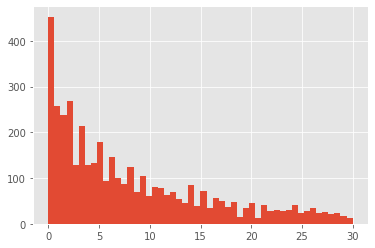

In [20]:
# How many days later did patients die after entering icu?
df[df.expire_flag==1]['los_death'].describe()
plt.hist(df[df.expire_flag==1]['los_death'], bins=50);

#### Age distributions for patients survived or died within 30 days

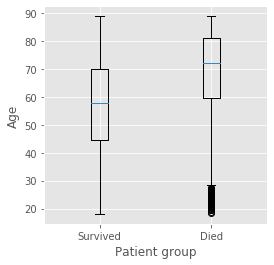

In [21]:
# died versus survived: age distribution
# Create a figure instance
fig = plt.figure(1, figsize=(4, 4))

# Create an axes instance
ax = fig.add_subplot(111);

# age_0: age of patients survived
age_0=df[df.expire_flag==0]['age']

# age_1: age of patients died
age_1=df[df.expire_flag==1]['age']

# boxplot
ax.boxplot([age_0, age_1]);
ax.set_xticklabels(['Survived', 'Died']);
ax.set_xlabel('Patient group');
ax.set_ylabel('Age');

#### Marital status distributions for patients all, survived or died within 30 days

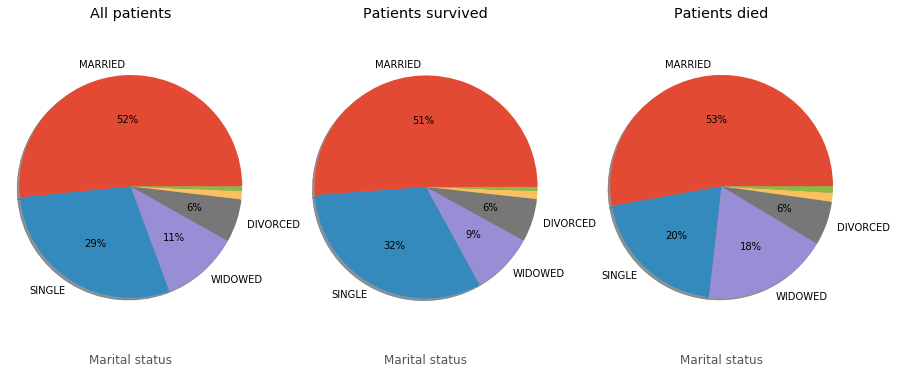

In [22]:
# died versus survived: marital_status distribution
df_sel=df.marital_status
df_sel0=df[df.expire_flag==0].marital_status
df_sel1=df[df.expire_flag==1].marital_status

# Cutoff percentage for display
pct_cutoff=2

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    """
    This function define whether to display the value based on the cutoff
    
    INPUT: 
        pct: threshold whether to display the value or not
        
    OUTPUT:
        return the format if value greater than threshold, else no display
    
    """
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure
fig= plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
# Slice the dataframe for the specific state and feature
df_temp=df_sel.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Marital status');
plt.title('All patients');


plt.subplot(1, 3, 2)
# Slice the dataframe for the specific state and feature
df_temp=df_sel0.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Marital status');
plt.title('Patients survived');



plt.subplot(1, 3, 3)
# Slice the dataframe for the specific state and feature
df_temp=df_sel1.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Marital status');
plt.title('Patients died');

#### Religion distributions for patients all, survived or died within 30 days

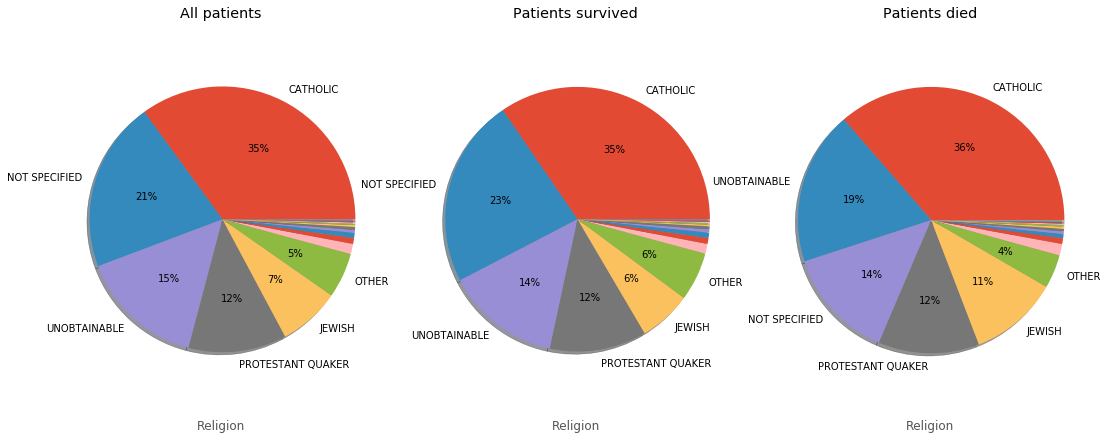

In [23]:
# died versus survived: religion distribution
df_sel=df.religion
df_sel0=df[df.expire_flag==0].religion
df_sel1=df[df.expire_flag==1].religion

# Cutoff percentage for display
pct_cutoff=2

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    """
    This function define whether to display the value based on the cutoff
    
    INPUT: 
        pct: threshold whether to display the value or not
        
    OUTPUT:
        return the format if value greater than threshold, else no display
    
    """
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure
fig= plt.figure(figsize=(18,7.2))

plt.subplot(1, 3, 1)
# Slice the dataframe for the specific state and feature
df_temp=df_sel.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Religion');
plt.title('All patients');


plt.subplot(1, 3, 2)
# Slice the dataframe for the specific state and feature
df_temp=df_sel0.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Religion');
plt.title('Patients survived');



plt.subplot(1, 3, 3)
# Slice the dataframe for the specific state and feature
df_temp=df_sel1.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Religion');
plt.title('Patients died');

#### Language distributions for patients all, survived or died within 30 days

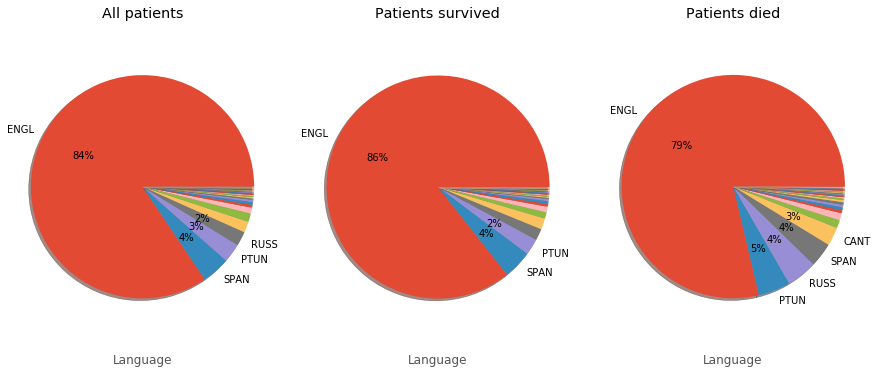

In [24]:
# died versus survived: language distribution
df_sel=df.language
df_sel0=df[df.expire_flag==0].language
df_sel1=df[df.expire_flag==1].language

# Cutoff percentage for display
pct_cutoff=2

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    """
    This function define whether to display the value based on the cutoff
    
    INPUT: 
        pct: threshold whether to display the value or not
        
    OUTPUT:
        return the format if value greater than threshold, else no display
    
    """
    
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure
fig= plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
# Slice the dataframe for the specific state and feature
df_temp=df_sel.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Language');
plt.title('All patients');


plt.subplot(1, 3, 2)
# Slice the dataframe for the specific state and feature
df_temp=df_sel0.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Language');
plt.title('Patients survived');



plt.subplot(1, 3, 3)
# Slice the dataframe for the specific state and feature
df_temp=df_sel1.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Language');
plt.title('Patients died');

#### Admission location distributions for patients all, survived or died within 30 days

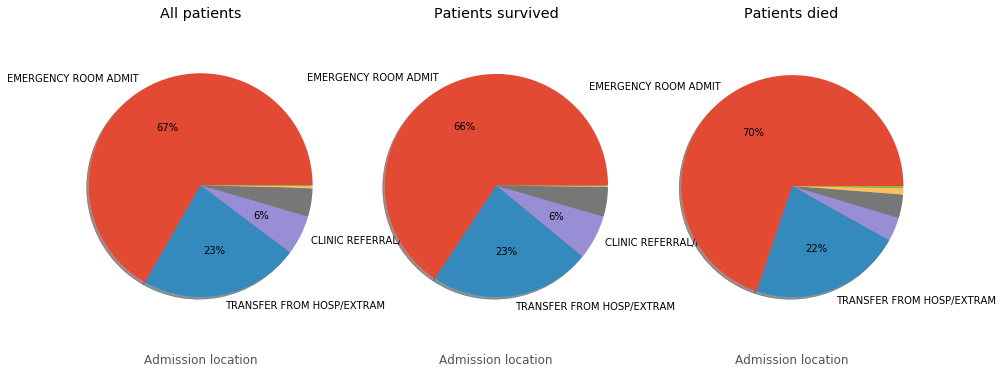

In [25]:
# died versus survived: admission_location distribution
df_sel=df.admission_location
df_sel0=df[df.expire_flag==0].admission_location
df_sel1=df[df.expire_flag==1].admission_location

# Cutoff percentage for display
pct_cutoff=5

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    """
    This function define whether to display the value based on the cutoff
    
    INPUT: 
        pct: threshold whether to display the value or not
        
    OUTPUT:
        return the format if value greater than threshold, else no display
    
    """
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure
fig= plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
# Slice the dataframe for the specific state and feature
df_temp=df_sel.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Admission location');
plt.title('All patients');


plt.subplot(1, 3, 2)
# Slice the dataframe for the specific state and feature
df_temp=df_sel0.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Admission location');
plt.title('Patients survived');



plt.subplot(1, 3, 3)
# Slice the dataframe for the specific state and feature
df_temp=df_sel1.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Admission location');
plt.title('Patients died');

#### Insurance distributions for patients all, survived or died within 30 days

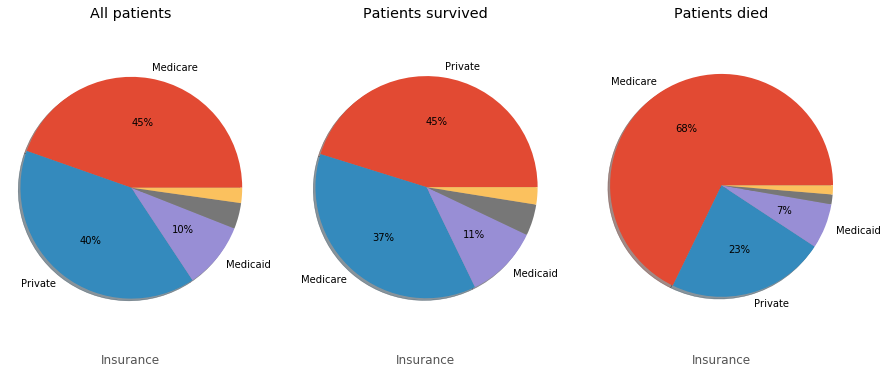

In [26]:
# died versus survived: insurance distribution
df_sel=df.insurance
df_sel0=df[df.expire_flag==0].insurance
df_sel1=df[df.expire_flag==1].insurance

# Cutoff percentage for display
pct_cutoff=5

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    """
    This function define whether to display the value based on the cutoff
    
    INPUT: 
        pct: threshold whether to display the value or not
        
    OUTPUT:
        return the format if value greater than threshold, else no display
    
    """
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure
fig= plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
# Slice the dataframe for the specific state and feature
df_temp=df_sel.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Insurance');
plt.title('All patients');


plt.subplot(1, 3, 2)
# Slice the dataframe for the specific state and feature
df_temp=df_sel0.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Insurance');
plt.title('Patients survived');



plt.subplot(1, 3, 3)
# Slice the dataframe for the specific state and feature
df_temp=df_sel1.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Insurance');
plt.title('Patients died');

#### Gender distributions for patients all, survived or died within 30 days

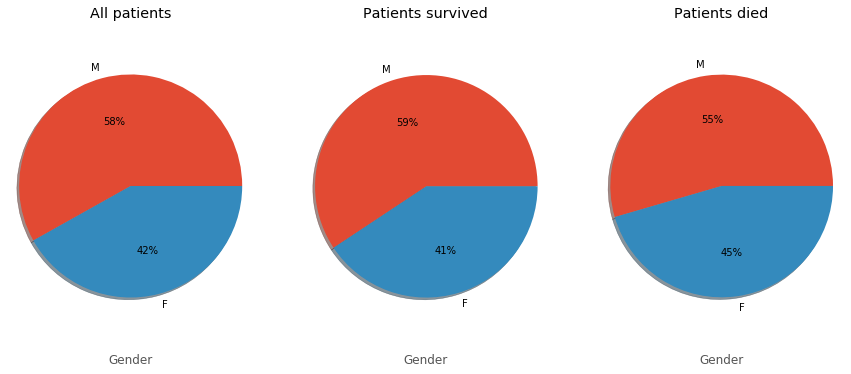

In [27]:
# died versus survived: gender distribution
df_sel=df.gender
df_sel0=df[df.expire_flag==0].gender
df_sel1=df[df.expire_flag==1].gender

# Cutoff percentage for display
pct_cutoff=5

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    """
    This function define whether to display the value based on the cutoff
    
    INPUT: 
        pct: threshold whether to display the value or not
        
    OUTPUT:
        return the format if value greater than threshold, else no display
    
    """
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure
fig= plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
# Slice the dataframe for the specific state and feature
df_temp=df_sel.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Gender');
plt.title('All patients');


plt.subplot(1, 3, 2)
# Slice the dataframe for the specific state and feature
df_temp=df_sel0.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Gender');
plt.title('Patients survived');



plt.subplot(1, 3, 3)
# Slice the dataframe for the specific state and feature
df_temp=df_sel1.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Gender');
plt.title('Patients died');

#### Ethinity distributions for patients all, survived or died within 30 days

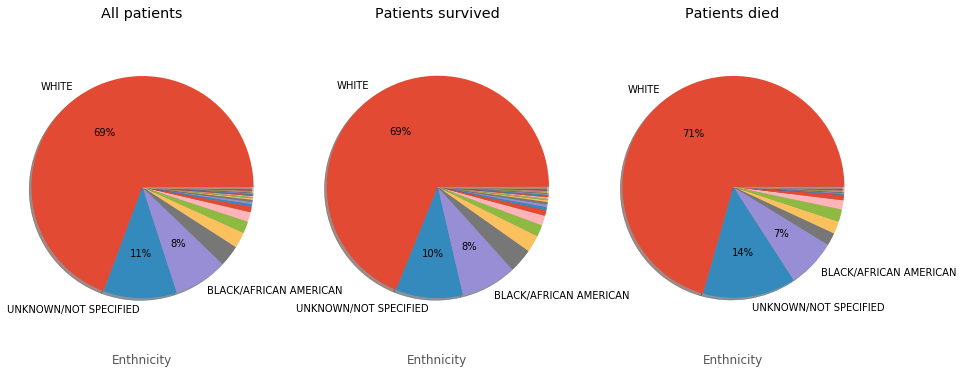

In [28]:
# died versus survived: ethinity distribution
df_sel=df.ethnicity
df_sel0=df[df.expire_flag==0].ethnicity
df_sel1=df[df.expire_flag==1].ethnicity

# Cutoff percentage for display
pct_cutoff=5

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    """
    This function define whether to display the value based on the cutoff
    
    INPUT: 
        pct: threshold whether to display the value or not
        
    OUTPUT:
        return the format if value greater than threshold, else no display
    
    """
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure
fig= plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
# Slice the dataframe for the specific state and feature
df_temp=df_sel.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Enthnicity');
plt.title('All patients');


plt.subplot(1, 3, 2)
# Slice the dataframe for the specific state and feature
df_temp=df_sel0.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Enthnicity');
plt.title('Patients survived');



plt.subplot(1, 3, 3)
# Slice the dataframe for the specific state and feature
df_temp=df_sel1.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel('Enthnicity');
plt.title('Patients died');

### <div align="center">4. Statistical Analysis & Hypothesis tests</div>

#### Age difference between patients survived and patients died

In [29]:
# age for patients survied versus patients died
age_surv=df[df.expire_flag==0].age
age_die=df[df.expire_flag==1].age

# age for all patients
age_all=df.age

# calcualte the average age for all patients, patients survived and patients died
mean_all=age_all.mean()
mean_surv=age_surv.mean()
mean_die=age_die.mean()

# calculate the difference in age between patients died and patients survived
mean_diff=mean_die-mean_surv

# calcualte the standard deviation in age for all patients, patients survived and patients died
std_all = age_all.std()
std_surv=age_surv.std()
std_die=age_die.std()

# print the values
print(f'The average age for all patients: {mean_all}. \
      \nThe average age for patients survived: {mean_surv}. \
      \nThe average age for patients died: {mean_die}. \
      \n\nDifference is {mean_diff}.')

print(f'\nThe standard deviation for all patients: {std_all}. \
      \nThe standard deviation for patients survived: {std_surv}. \
      \nThe standard deviation for patients died: {std_die}.')

The average age for all patients: 59.56914136971059.       
The average age for patients survived: 56.4526304806014.       
The average age for patients died: 69.03682122991746.       

Difference is 12.584190749316065.

The standard deviation for all patients: 17.704963625829972.       
The standard deviation for patients survived: 17.5150211034652.       
The standard deviation for patients died: 14.652512551301475.


#### Histogram

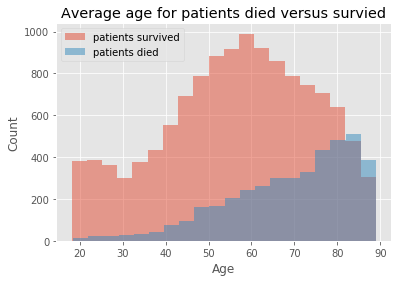

In [30]:
# histogram for patients survived and patients died
plt.hist(age_surv, alpha = 0.5,  bins=20, label='patients survived');
plt.hist(age_die, alpha=0.5, bins=20, label='patients died'); 
plt.legend();
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Average age for patients died versus survied');

#### Empirical Cumulative Distribution Function (ECDF)

In [31]:
# define a function to get the empirical cumulative distribution function 
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

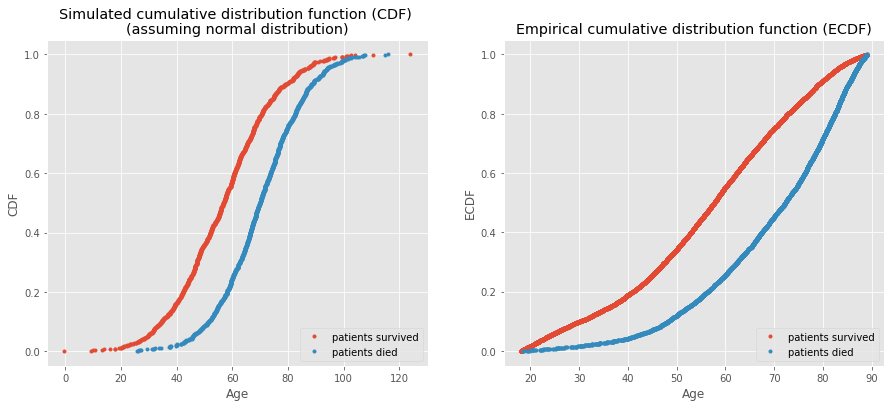

In [32]:
# make a figure with both cdf (theoretical cumulative distribution fuction based on a distribution)
# and ecdf (empirical cumulative distribution function based on the actual data)

# define the size of the figure
fig= plt.figure(figsize=(15,6))

# subplot no. 1 for cdf
plt.subplot(1, 2, 1)

# Compute CDFs
# set the seed for reproducibility
np.random.seed(42)

# simulate two samples for patients survived and patients died, assuming both normal distribution
age_surv_sample=np.random.normal(mean_surv, std_surv, size =1000)
age_die_sample=np.random.normal(mean_die, std_die, size =1000)

# calculate the cumulative distribution function from the simulated theoretical data
x_surv_sample, y_surv_sample = ecdf(age_surv_sample)
x_die_sample, y_die_sample = ecdf(age_die_sample)

# Plot the CDFs
_ = plt.plot(x_surv_sample, y_surv_sample, marker='.', linestyle='none')
_ = plt.plot(x_die_sample, y_die_sample, marker='.', linestyle='none')

# Add axis labels and legend
_ = plt.xlabel('Age')
_ = plt.ylabel('CDF')
_ = plt.legend(('patients survived', 'patients died'), loc='lower right')
_ = plt.title("Simulated cumulative distribution function (CDF) \n(assuming normal distribution)")


# subplot no. 2 for ecdf based on this dataset
plt.subplot(1, 2, 2)

# Compute ECDFs based on this dataset
x_surv, y_surv = ecdf(age_surv)
x_die, y_die = ecdf(age_die)

# Plot the ECDFs
_ = plt.plot(x_surv, y_surv, marker='.', linestyle='none')
_ = plt.plot(x_die, y_die, marker='.', linestyle='none')

# Add axis labels and legend
_ = plt.xlabel('Age')
_ = plt.ylabel('ECDF')
_ = plt.legend(('patients survived', 'patients died'), loc='lower right')
_ = plt.title("Empirical cumulative distribution function (ECDF)")


# Show the plot
plt.show()

Note: As ECDF is quite different from CDF, indicating it's not a normal distribution. Patients survived is closer to normal distribution than patients died.

#### Bootstrap & p-value

In [33]:
# define some function to generate bootstrap samples

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

In [34]:
# Get bootstrap replicates of means
bs_replicates_surv = draw_bs_reps(age_surv, np.mean, size = 10000)
bs_replicates_die = draw_bs_reps(age_die, np.mean, size = 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_die - bs_replicates_surv

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5,97.5])

# Print the results
print('Difference of means =', mean_diff, 'years.')
print('95% confidence interval =', conf_int, 'years.')

Difference of means = 12.584190749316065 years.
95% confidence interval = [12.04333609 13.12803455] years.


Note: The 95% confidence interval to observe the difference in the average age of 12.58 is betwwen 12.04 and 13.12 years.

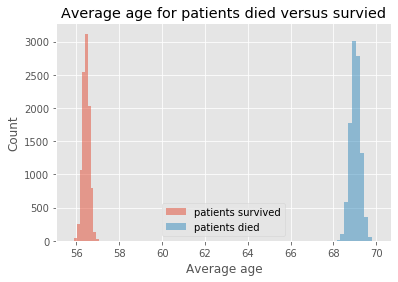

In [35]:
# make histogram of bootstrap samples for patients survived and patients died
plt.hist(bs_replicates_surv, alpha = 0.5, label='patients survived');
plt.hist(bs_replicates_die, alpha = 0.5, label='patients died'); 
plt.legend();
plt.xlabel('Average age');
plt.ylabel('Count');
plt.title('Average age for patients died versus survied');

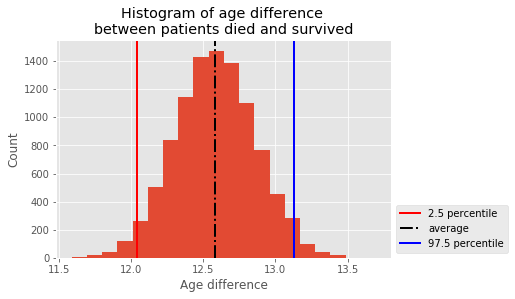

In [36]:
# calcualte the low and upper boundaries for the 95% confidence interval
low, upper = conf_int[0], conf_int[1]

# make a histogram with low, upper boundaries and 
# observed age diference between patients died and patiens survived
plt.hist(bs_diff_replicates, bins=20);
plt.axvline(x=low, color='red', linewidth=2, label='2.5 percentile');
plt.axvline(x=mean_diff, color='black', linewidth=2, linestyle='dashdot', label='average');
plt.axvline(x=upper, color='blue', linewidth=2, label='97.5 percentile');
plt.xlabel('Age difference');
plt.ylabel('Count');
plt.title('Histogram of age difference \nbetween patients died and survived');
plt.legend(loc='lower left', bbox_to_anchor=(1, 0));

In [37]:
# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.4983


Note: This indicates that the probability of observing this observed age difference or bigger is at least 49.83%. 

#### Bootstrap & null hypothesis: no difference in average age

Shift the data for patients survived and patients died so that the two groups have the same average age. The null hypothesis is that they have the same average age. 

In [38]:
# Mean of all patients: mean_all

# Shift the samples
age_surv_shifted = age_surv - mean_surv + mean_all
age_die_shifted = age_die - mean_die + mean_all

# Get bootstrap replicates of shifted data sets
bs_replicates_surv_shifted = draw_bs_reps(age_surv_shifted,np.mean, size=10000)
bs_replicates_die_shifted = draw_bs_reps(age_die_shifted,np.mean, size=10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates_shifted = bs_replicates_die_shifted - bs_replicates_surv_shifted

# Compute 95% confidence interval: conf_int_shifted
conf_int_shifted = np.percentile(bs_diff_replicates_shifted, [2.5,97.5])

# Print the results
print('95% confidence interval =', conf_int_shifted, 'years.')

95% confidence interval = [-0.55057084  0.53621634] years.


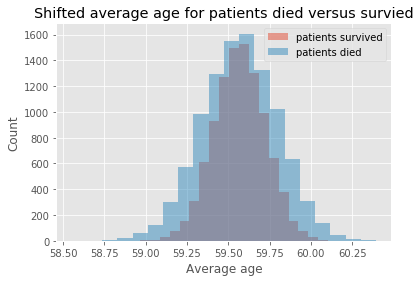

In [39]:
# make histogram with age-shifted data
plt.hist(bs_replicates_surv_shifted, alpha = 0.5, bins=20, label='patients survived');
plt.hist(bs_replicates_die_shifted, alpha = 0.5, bins=20, label='patients died'); 
plt.legend();
plt.xlabel('Average age');
plt.ylabel('Count');
plt.title('Shifted average age for patients died versus survied');

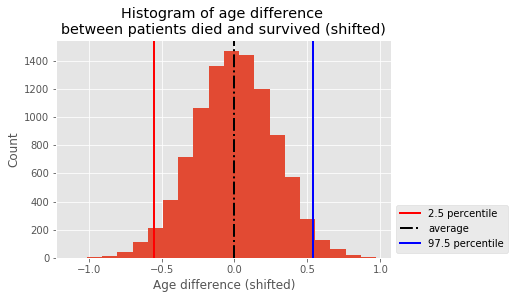

In [40]:
# calculate the low and upper boundaries for this age-shifted data
low_shifted, upper_shifted = conf_int_shifted[0], conf_int_shifted[1]

# make a histogram
plt.hist(bs_diff_replicates_shifted, bins=20);
plt.axvline(x=low_shifted, color='red', linewidth=2, label='2.5 percentile');
plt.axvline(x=0, color='black', linewidth=2, linestyle='dashdot', label='average');
plt.axvline(x=upper_shifted, color='blue', linewidth=2, label='97.5 percentile');
plt.xlabel('Age difference (shifted)');
plt.ylabel('Count');
plt.title('Histogram of age difference \nbetween patients died and survived (shifted)');
plt.legend(loc='lower left', bbox_to_anchor=(1, 0));

In [41]:
# Compute the p-value
p = np.sum(bs_diff_replicates_shifted >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0


As p value is zero, this means that the probability of observing this actual age difference is zero if the average ages of the two groups (patients died and patients survived) are the same.

As a consequnce, this null hypothesis is rejected. In other words, the average ages of patients survived and patients died are not equal.

#### Gender difference

In [42]:
# get the death rate for male and female respectively

# slice the data for male
df_m=df[df.gender=='M']
# slice the data for female
df_f=df[df.gender=='F']

# death rate for all patients
death_all=df.expire_flag.value_counts(normalize=True)[1]

# death rate for female
death_f=df_f.expire_flag.value_counts(normalize=True)[1]

# death rate for male
death_m=df_m.expire_flag.value_counts(normalize=True)[1]

# death rate difference
death_diff=death_f-death_m

#### bootstrap

In [43]:
# get bootstrap samples for male and female patients

death_m, death_f, diffs=[], [], []

n_pat=df.shape[0]

for _ in range(10000):
    
    bootsample=df.sample(n_pat, replace=True)
        
    death_m_boot=bootsample[bootsample.gender=='M'].expire_flag.value_counts(normalize=True)[1]
    
    death_f_boot=bootsample[bootsample.gender=='F'].expire_flag.value_counts(normalize=True)[1]
    
    death_m.append(death_m_boot)
    
    death_f.append(death_f_boot)
    
    diffs.append(death_f_boot - death_m_boot)

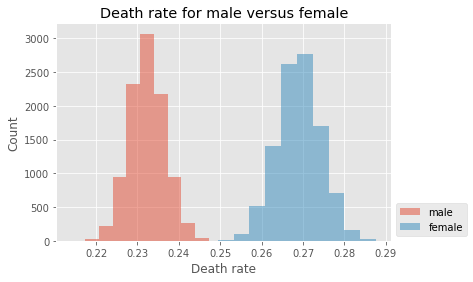

In [44]:
# make histogram
plt.hist(death_m, alpha = 0.5, label='male');
plt.hist(death_f, alpha = 0.5, label='female'); 
plt.legend(loc='lower left', bbox_to_anchor=(1, 0));
plt.xlabel('Death rate');
plt.ylabel('Count');
plt.title('Death rate for male versus female');

In [45]:
# Compute 95% confidence interval: conf_int
conf_int = np.percentile(diffs, [2.5,97.5])
low, upper = conf_int[0], conf_int[1]

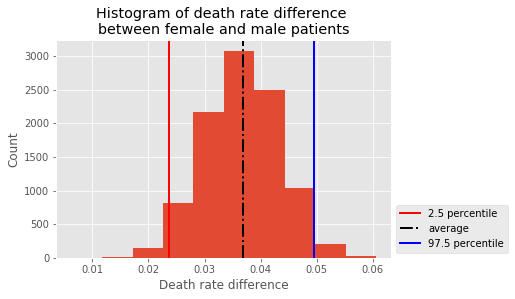

In [46]:
# make histogram
plt.hist(diffs);
plt.axvline(x=low, color='red', linewidth=2, label='2.5 percentile');
plt.axvline(x=death_diff, color='black', linewidth=2, linestyle='dashdot', label='average');
plt.axvline(x=upper, color='blue', linewidth=2, label='97.5 percentile');
plt.xlabel('Death rate difference');
plt.ylabel('Count');
plt.title('Histogram of death rate difference \nbetween female and male patients');
plt.legend(loc='lower left', bbox_to_anchor=(1, 0));

In [47]:
# Compute the p-value
p = np.sum(diffs >= death_diff) / len(diffs)

# Print p-value
print('p =', p)

p = 0.4954


Note: This means that the probability of observing death rate difference at least or larger than the actual observed difference is 49.54%. 

### <div align="center">5. Natural Language Processing based Machine Learning Pipelines</div>
    a. Logistic Regression
    b. Random Forest Classification

#### Machine learning models and train-test split

In [48]:
# import libraries
import time
import pickle
import re
import nltk
nltk.download(['punkt','wordnet','averaged_perceptron_tagger','stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rzhou11\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rzhou11\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rzhou11\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rzhou11\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# split the data into training and test sets
# join the columns together as a single string
X = df['age'].astype(str) + ' ' + df['gender'] + ' ' + df['admission_type'] + ' ' + df['admission_location'] + ' ' + df['insurance'] + ' '  + df['ethnicity'] + ' ' + df['diagnosis'] + ' ' +  df['text'] 

# target is the death in hospital within 30 days
y = df['expire_flag']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# print the shape
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}.')

X_train shape: (12462,), X_test shape: (4154,), y_train shape: (12462,), y_test shape: (4154,).


In [50]:
# define a function to interpret the text, splitting to tokens

def tokenize(text):
    """
    This function clean the text based on word_tokenize, WordNetLemmatizer and return tokens
    
    INPUT: unstructured text
    
    OUTPUT: processed clean tokens ready for machine learning pipelines
    
    """      
       
    # extrac text based on the pattern
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # get tokens and remove stopwords
    tokens = word_tokenize(text)
    
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

#### 5a. Logistic Regression

In [51]:
# build a logistic regression pipeline
pipeline_LR = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", LogisticRegression())])

# fit the model base on training data
time_begin = time.time()
pipeline_LR.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')

# predict the test data
time_begin = time.time()
y_pred = pipeline_LR.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'Classification Report for Logistic Regression: \n{report}')

acc=accuracy_score(y_test, y_pred)
# print the accuracy score
print(f'\nAccuracy score for Logistic Regression: {acc}.')

It took 9.75 minutes to fit the model.
It took 3.2 minutes to make predictions.
Classification Report for Logistic Regression: 
              precision    recall  f1-score   support

    survived       0.85      0.96      0.90      3142
        died       0.79      0.48      0.60      1012

    accuracy                           0.84      4154
   macro avg       0.82      0.72      0.75      4154
weighted avg       0.84      0.84      0.83      4154


Accuracy score for Logistic Regression: 0.843042850264805.


#### 5b. Random Forest

In [52]:
# build a random forest pipeline
pipeline_RF = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", RandomForestClassifier(random_state=42))])

# fit the model base on training data
time_begin = time.time()
pipeline_RF.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')

# predict the test data
time_begin = time.time()
y_pred = pipeline_RF.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'Classification Report for Random Forest: \n{report}')

acc=accuracy_score(y_test, y_pred)
# print the accuracy score
print(f'\nAccuracy score for Random Forest: {acc}.')

It took 9.98 minutes to fit the model.
It took 3.21 minutes to make predictions.
Classification Report for Random Forest: 
              precision    recall  f1-score   support

    survived       0.78      0.99      0.87      3142
        died       0.87      0.11      0.20      1012

    accuracy                           0.78      4154
   macro avg       0.82      0.55      0.53      4154
weighted avg       0.80      0.78      0.71      4154


Accuracy score for Random Forest: 0.7792489167067886.


### <div align="center">6. Undersampling for inbalanced dataset</div>

#### Imbalanced dataset

As the data has more than 75% of survived patients, machine learning algorithms didn't perform well for the minority.

In [53]:
# check the composition of the inbalanced dataset
df.expire_flag.value_counts(normalize=True)

0    0.752347
1    0.247653
Name: expire_flag, dtype: float64

#### Balanced dataset: undersampling

Data engieering:

Under-sample the major data with patients survived, using pandas' sampling feature without replacement to generate balanced data sets between survived and died patient groups. This allows machine learning algorithms to train and fit properly, improving the performance on minor data set.

In [54]:
# separate the dataframe into two datasets based on the expire_flag value (died or not)
# patients died as df1
df1=df[df.expire_flag==1]
print(f'Shape of dataframe for patients died: {df1.shape}.')

# patients survived as df0
df0=df[df.expire_flag==0]
print(f'Shape of dataframe for patients survived: {df0.shape}.')

# undersampling the dataframe for patients survived based on the size of the patients died
df0u=df0.sample(frac=df1.shape[0]/df0.shape[0], replace=False, random_state=1)
print(f'Shape of dataframe for patients survived after undersampling: {df0u.shape}.')

Shape of dataframe for patients died: (4115, 18).
Shape of dataframe for patients survived: (12501, 18).
Shape of dataframe for patients survived after undersampling: (4115, 18).


In [55]:
# Join undersampled dataframe for patients survived with that for patients died 
# to get the new dataframe
df=pd.concat([df1, df0u], ignore_index=True)
print(f'Shape of new dataframe after undersampling: {df.shape}.')

Shape of new dataframe after undersampling: (8230, 18).


#### Save balanced dataset

In [56]:
# save the dataframe for future use
df.to_csv('..\data\mimic_mortality_balanced.csv', index=False)

### <div align="center">7. Exploratory Data Analysis for Balanced Dataset</div>

#### Age distributions for patients survived or died within 30 days after balancing

Age was selected between 18 and 100.

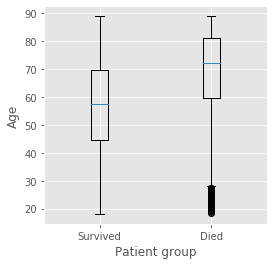

In [57]:
# died versus survived: age distribution
# Create a figure instance
fig = plt.figure(1, figsize=(4, 4))

# Create an axes instance
ax = fig.add_subplot(111);

# age_0: age of patients survived
age_0=df[df.expire_flag==0]['age']

# age_1: age of patients died
age_1=df[df.expire_flag==1]['age']

# boxplot
ax.boxplot([age_0, age_1]);
ax.set_xticklabels(['Survived', 'Died']);
ax.set_xlabel('Patient group');
ax.set_ylabel('Age');

#### Insurance distributions for patients all, survived or died within 30 days after balancing

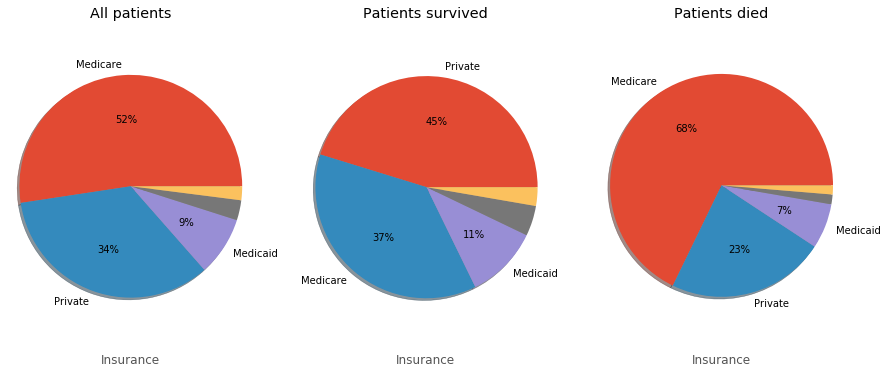

In [58]:
# died versus survived: insurance distribution
feature='insurance'

df_sel=df[feature]
df_sel0=df[df.expire_flag==0][feature]
df_sel1=df[df.expire_flag==1][feature]

# Cutoff percentage for display
pct_cutoff=5

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    """
    This function define whether to display the value based on the cutoff
    
    INPUT: 
        pct: threshold whether to display the value or not
        
    OUTPUT:
        return the format if value greater than threshold, else no display
    
    """
    
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure
fig= plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
# Slice the dataframe for the specific state and feature
df_temp=df_sel.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel(feature.capitalize());
plt.title('All patients');


plt.subplot(1, 3, 2)
# Slice the dataframe for the specific state and feature
df_temp=df_sel0.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel(feature.capitalize());
plt.title('Patients survived');



plt.subplot(1, 3, 3)
# Slice the dataframe for the specific state and feature
df_temp=df_sel1.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel(feature.capitalize());
plt.title('Patients died');

#### Gender distributions for patients all, survived or died within 30 days after balancing

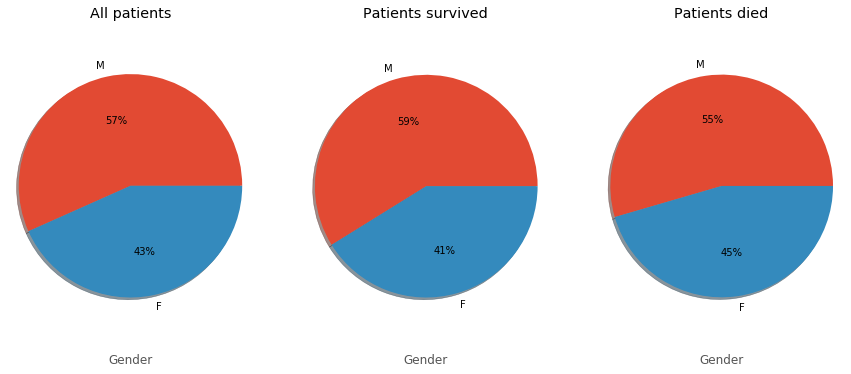

In [59]:
# died versus survived: gender distribution
feature='gender'

df_sel=df[feature]
df_sel0=df[df.expire_flag==0][feature]
df_sel1=df[df.expire_flag==1][feature]

# Cutoff percentage for display
pct_cutoff=5

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    """
    This function define whether to display the value based on the cutoff
    
    INPUT: 
        pct: threshold whether to display the value or not
        
    OUTPUT:
        return the format if value greater than threshold, else no display
    
    """
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''

# Set the size of the figure
fig= plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
# Slice the dataframe for the specific state and feature
df_temp=df_sel.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel(feature.capitalize());
plt.title('All patients');


plt.subplot(1, 3, 2)
# Slice the dataframe for the specific state and feature
df_temp=df_sel0.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel(feature.capitalize());
plt.title('Patients survived');



plt.subplot(1, 3, 3)
# Slice the dataframe for the specific state and feature
df_temp=df_sel1.value_counts(normalize=True)

# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
          for n, v in zip(df_temp.index, df_temp)] 

# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True);
# Set axis,label and title
plt.axis('equal');
plt.xlabel(feature.capitalize());
plt.title('Patients died');

#### Top 10 diagnoses for different patient groups after balancing

In [60]:
# died versus survived: diagnoses distribution
feature='diagnosis'

# slice different patient groups
df_sel=df[feature]
df_sel0=df[df.expire_flag==0][feature]
df_sel1=df[df.expire_flag==1][feature]

In [61]:
# top 10 diagnoses for all patients in this data set
dig_dic_all = df_sel.value_counts()[:10].to_dict()

# top 10 diagnoses for patients died in this data set
dig_dic_die = df_sel1.value_counts()[:10].to_dict()

# top 10 diagnoses for patients survived in this data set
dig_dic_sur = df_sel0.value_counts()[:10].to_dict()


print(f'Top 10 diagnosis for all patients: {dig_dic_all}.\n')
print(f'Top 10 diagnosis for died patients: {dig_dic_die}.\n')
print(f'Top 10 diagnosis for survived patients: {dig_dic_sur}.\n')

Top 10 diagnosis for all patients: {'PNEUMONIA': 261, 'SEPSIS': 248, 'INTRACRANIAL HEMORRHAGE': 172, 'CORONARY ARTERY DISEASE': 169, 'CONGESTIVE HEART FAILURE': 137, 'CHEST PAIN': 132, 'ALTERED MENTAL STATUS': 111, 'GASTROINTESTINAL BLEED': 104, 'SUBARACHNOID HEMORRHAGE': 103, 'ABDOMINAL PAIN': 98}.

Top 10 diagnosis for died patients: {'PNEUMONIA': 185, 'SEPSIS': 182, 'INTRACRANIAL HEMORRHAGE': 110, 'CONGESTIVE HEART FAILURE': 95, 'ABDOMINAL PAIN': 56, 'ALTERED MENTAL STATUS': 54, 'HYPOTENSION': 52, 'GASTROINTESTINAL BLEED': 51, 'S/P FALL': 48, 'FEVER': 42}.

Top 10 diagnosis for survived patients: {'CORONARY ARTERY DISEASE': 146, 'CHEST PAIN': 100, 'PNEUMONIA': 76, 'SEPSIS': 66, 'SUBARACHNOID HEMORRHAGE': 65, 'INTRACRANIAL HEMORRHAGE': 62, 'ALTERED MENTAL STATUS': 57, 'GASTROINTESTINAL BLEED': 53, 'S/P FALL': 50, 'S/P MOTOR VEHICLE ACCIDENT': 50}.



#### Most dangerous diagnoses (low survival rate) after balancing

Most dangerous diagnoses:

{'SEPSIS': 73.39, 'PNEUMONIA': 70.88, 'CONGESTIVE HEART FAILURE': 69.34, 'INTRACRANIAL HEMORRHAGE': 63.95, 'ABDOMINAL PAIN': 57.14, 'GASTROINTESTINAL BLEED': 49.04, 'ALTERED MENTAL STATUS': 48.65}


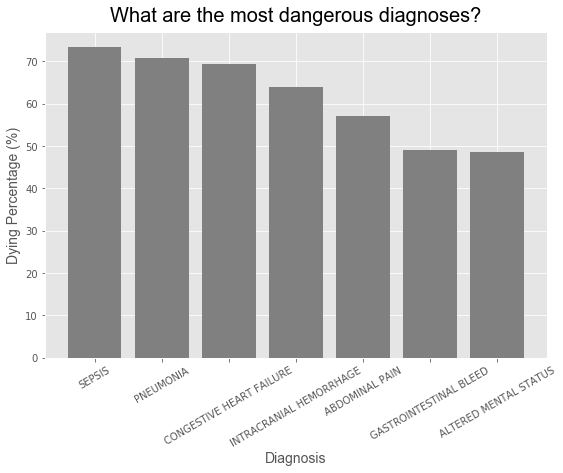

In [62]:
# Most dangerous dignoses (low survival rate)

# initiate an empty dictionary
dig_top={}

# search the top 10 diagnoses dictionary for the died patient group
# if it is also in the top 10 for the all patient group, get the percentage

for key, val in dig_dic_die.items():    
    if key in dig_dic_all.keys():
        dig_top[key]= round(val/dig_dic_all.get(key)*100,2)
        
# sort the dictionary based on the percentage
dig_top={k: v for k, v in sorted(dig_top.items(), key=lambda item: item[1], reverse=True)}

print(f'Most dangerous diagnoses:\n')
print(dig_top)

# Set the size of the figure
fig= plt.figure(figsize=(9,6))

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'14'}

plt.bar(dig_top.keys(), dig_top.values(), color='grey')
plt.xticks(rotation=30)
plt.ylabel('Dying Percentage (%)', **axis_font)
plt.xlabel('Diagnosis', **axis_font)
plt.title('What are the most dangerous diagnoses?', **title_font)
plt.show()

### <div align="center">7. Natural Language Processing based Machine Learning Pipelines: Balanced Dataset</div>

#### Machine learning models and train-test split

In [63]:
# List of classification algorithms
algo_lst=['Logistic Regression','K-Nearest Neighbors','Decision Trees','Random Forest', 'AdaBoost', 'XGBoost', 'Naive Bayes', 'Support Vector Machine']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

In [64]:
# split the data into training and test sets
# join the columns together as a single string
X = df['age'].astype(str) + ' ' + df['gender'] + ' ' + df['admission_type'] + ' ' + df['admission_location'] + ' ' + df['insurance'] + ' '  + df['ethnicity'] + ' ' + df['diagnosis'] + ' ' +  df['text'] 

# target is the death in hospital within 30 days
y = df['expire_flag']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# print the shape
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}.')

X_train shape: (6172,), X_test shape: (2058,), y_train shape: (6172,), y_test shape: (2058,).


#### 7a. Logistic Regression

In [65]:
# build a logistic regression pipeline
pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", LogisticRegression())])

# fit the model base on training data
time_begin = time.time()
pipeline.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')

# predict the test data
time_begin = time.time()
y_pred = pipeline.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'\nClassification Report for Logistic Regression: \n{report}')

acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

# print the accuracy score
print(f'\nAccuracy score for Logistic Regression: {acc}.')

It took 4.82 minutes to fit the model.
It took 1.65 minutes to make predictions.

Classification Report for Logistic Regression: 
              precision    recall  f1-score   support

    survived       0.83      0.81      0.82      1038
        died       0.81      0.83      0.82      1020

    accuracy                           0.82      2058
   macro avg       0.82      0.82      0.82      2058
weighted avg       0.82      0.82      0.82      2058


Accuracy score for Logistic Regression: 0.8168124392614189.


#### 7b. K-Nearest Neighbors

In [66]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", knn)])

# fit the model base on training data
time_begin = time.time()
pipeline.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')

# predict the test data
time_begin = time.time()
y_pred = pipeline.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'\nClassification Report for K-Nearest Neighbors: \n{report}')

acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

# print the accuracy score
print(f'\nAccuracy score for K-Nearest Neighbors: {acc}.')

It took 4.81 minutes to fit the model.
It took 1.67 minutes to make predictions.

Classification Report for K-Nearest Neighbors: 
              precision    recall  f1-score   support

    survived       0.67      0.78      0.72      1038
        died       0.73      0.60      0.66      1020

    accuracy                           0.69      2058
   macro avg       0.70      0.69      0.69      2058
weighted avg       0.70      0.69      0.69      2058


Accuracy score for K-Nearest Neighbors: 0.6938775510204082.


#### 7c. Decision Trees

In [67]:
# Create a decision trees
dt=DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)

pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", dt)])

# fit the model base on training data
time_begin = time.time()
pipeline.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')

# predict the test data
time_begin = time.time()
y_pred = pipeline.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'\nClassification Report for Decision Trees: \n{report}')

acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

# print the accuracy score
print(f'\nAccuracy score for Decision Trees: {acc}.')

It took 4.84 minutes to fit the model.
It took 1.65 minutes to make predictions.

Classification Report for Decision Trees: 
              precision    recall  f1-score   support

    survived       0.69      0.71      0.70      1038
        died       0.70      0.67      0.68      1020

    accuracy                           0.69      2058
   macro avg       0.69      0.69      0.69      2058
weighted avg       0.69      0.69      0.69      2058


Accuracy score for Decision Trees: 0.6924198250728864.


#### 7d. Random Forest

In [68]:
# build a random forest pipeline
pipeline_RF = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", RandomForestClassifier(random_state=42))])

# fit the model base on training data
time_begin = time.time()
pipeline_RF.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')

# predict the test data
time_begin = time.time()
y_pred = pipeline_RF.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'\nClassification Report for Random Forest: \n{report}')

acc=accuracy_score(y_test, y_pred)
# Append to the accuracy list
accuracy_lst.append(acc)

# print the accuracy score
print(f'\nAccuracy score for Random Forest: {acc}.')

It took 4.93 minutes to fit the model.
It took 1.65 minutes to make predictions.

Classification Report for Random Forest: 
              precision    recall  f1-score   support

    survived       0.78      0.79      0.79      1038
        died       0.79      0.77      0.78      1020

    accuracy                           0.78      2058
   macro avg       0.78      0.78      0.78      2058
weighted avg       0.78      0.78      0.78      2058


Accuracy score for Random Forest: 0.781827016520894.


#### 7e. AdaBoost

In [69]:
# build an adaboost pipeline
pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", AdaBoostClassifier())])

# fit the model base on training data
time_begin = time.time()
pipeline.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')

# predict the test data
time_begin = time.time()
y_pred = pipeline.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'\nClassification Report for AdaBoost: \n{report}')

acc=accuracy_score(y_test, y_pred)
# Append to the accuracy list
accuracy_lst.append(acc)

# print the accuracy score
print(f'\nAccuracy score for AdaBoost: {acc}.')

It took 4.93 minutes to fit the model.
It took 1.65 minutes to make predictions.

Classification Report for AdaBoost: 
              precision    recall  f1-score   support

    survived       0.77      0.77      0.77      1038
        died       0.77      0.76      0.76      1020

    accuracy                           0.77      2058
   macro avg       0.77      0.77      0.77      2058
weighted avg       0.77      0.77      0.77      2058


Accuracy score for AdaBoost: 0.7672497570456754.


#### 7f. XGBoost

In [70]:
# build a XGBoost pipeline
# options: max_depth=3, n_estimators=300, learning_rate=0.05

xgb = XGBClassifier()

pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", xgb)])

# fit the model base on training data
time_begin = time.time()
pipeline.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')

# predict the test data
time_begin = time.time()
y_pred = pipeline.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'\nClassification Report for XGBoost: \n{report}')

acc=accuracy_score(y_test, y_pred)
# Append to the accuracy list
accuracy_lst.append(acc)

# print the accuracy score
print(f'\nAccuracy score for XGBoost: {acc}.')

It took 5.06 minutes to fit the model.
It took 1.64 minutes to make predictions.

Classification Report for XGBoost: 
              precision    recall  f1-score   support

    survived       0.79      0.80      0.79      1038
        died       0.79      0.78      0.79      1020

    accuracy                           0.79      2058
   macro avg       0.79      0.79      0.79      2058
weighted avg       0.79      0.79      0.79      2058


Accuracy score for XGBoost: 0.7886297376093294.


#### 7g. Naive bayes

In [71]:
# build a Gaussian Naive Bayes pipeline
from sklearn.naive_bayes import MultinomialNB

mnb=MultinomialNB()

pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", mnb)])

# fit the model base on training data
time_begin = time.time()
pipeline.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')


It took 4.83 minutes to fit the model.


In [72]:
# predict the test data
time_begin = time.time()
y_pred = pipeline.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'\nClassification Report for Naive Bayes: \n{report}')

acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

# print the accuracy score
print(f'\nAccuracy score for Naive Bayes: {acc}.')

It took 1.66 minutes to make predictions.

Classification Report for Naive Bayes: 
              precision    recall  f1-score   support

    survived       0.82      0.75      0.78      1038
        died       0.77      0.83      0.80      1020

    accuracy                           0.79      2058
   macro avg       0.79      0.79      0.79      2058
weighted avg       0.79      0.79      0.79      2058


Accuracy score for Naive Bayes: 0.7910592808551993.


#### 7h. Support vector machine

In [73]:
# build a Support Vector Machine pipeline
from sklearn.svm import SVC
svm = SVC()

pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", svm)])

# fit the model base on training data
time_begin = time.time()
pipeline.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')

# predict the test data
time_begin = time.time()
y_pred = pipeline.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'\nClassification Report for Support Vector Machine: \n{report}')

acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

# print the accuracy score
print(f'\nAccuracy score for Support Vector Machine: {acc}.')

It took 5.51 minutes to fit the model.
It took 1.85 minutes to make predictions.

Classification Report for Support Vector Machine: 
              precision    recall  f1-score   support

    survived       0.83      0.80      0.82      1038
        died       0.81      0.83      0.82      1020

    accuracy                           0.82      2058
   macro avg       0.82      0.82      0.82      2058
weighted avg       0.82      0.82      0.82      2058


Accuracy score for Support Vector Machine: 0.8168124392614189.


#### Accuracy comparison for different classification models

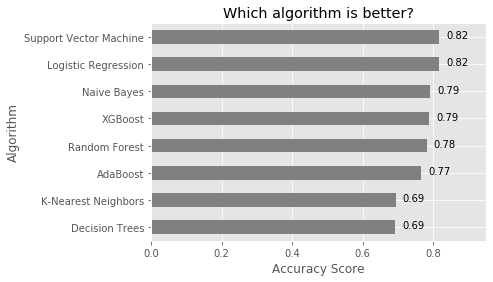

In [74]:
# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,0.95)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('Which algorithm is better?')

plt.show()

Note: Results indicate that Support Vector Machine and Logistic Regression algorithms are the best two for this classification problem.

#### Print the accuracy scores and save it for future use

In [75]:
# print accuracy scores
df_acc

,Algorithm,Accuracy_Score
2,Decision Trees,0.692420
1,K-Nearest Neighbors,0.693878
4,AdaBoost,0.767250
3,Random Forest,0.781827
5,XGBoost,0.788630
6,Naive Bayes,0.791059
0,Logistic Regression,0.816812
7,Support Vector Machine,0.816812


In [76]:
# save
df_acc.to_csv(r'..\data\acc_score.csv', index=False)

### <div align="center">8. Model Evaluation & Optimization</div>

### 8a. Use different NLP library: spaCy

In [77]:
# import libraries
import spacy
import en_core_sci_lg
nlp = spacy.load("en_core_sci_lg")

In [78]:
# define a function to interpret the text, splitting to tokens

def tokenize_spacy(text):
    """
    split text into meaningful tokens
    
    INPUT: text
    
    OUTPUT: clean tokens
    """
   
    doc = nlp(text)
    
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    lemmas = [token.lemma_ for token in doc]
    
    clean_tokens = [lemma.lower().strip() for lemma in lemmas if lemma not in stopwords]
    
    return clean_tokens

In [79]:
# build a logistic regression pipeline
pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize_spacy)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", LogisticRegression())])

# fit the model base on training data
time_begin = time.time()
print('Starting fitting...')
pipeline.fit(X_train, y_train)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to fit the model.')

Starting fitting...
It took 5.51 minutes to fit the model.


In [80]:
# predict the test data
time_begin = time.time()
print('Starting predicting...')
y_pred = pipeline.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'\nClassification Report for Logistic Regression: \n{report}')

acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

# print the accuracy score
print(f'\nAccuracy score for Logistic Regression: {acc}.')

Starting predicting...
It took 1.87 minutes to make predictions.

Classification Report for Logistic Regression: 
              precision    recall  f1-score   support

    survived       0.81      0.80      0.80      1038
        died       0.80      0.81      0.80      1020

    accuracy                           0.80      2058
   macro avg       0.80      0.80      0.80      2058
weighted avg       0.80      0.80      0.80      2058


Accuracy score for Logistic Regression: 0.8032069970845481.


Note: It looks like the performance with spaCy is not as good as that with NLTK.

### 8b. Optimize the logistic regression pipeline

In [81]:
# optimize a logistic regression pipeline
logreg=LogisticRegression()

pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", logreg)])


parameters = {
    "clf__penalty": ['l1','l2'],
    "clf__C" : [0.1,1,10]    
    }

cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, cv=5, verbose=2)

time_begin = time.time()

cv.fit(X_train, y_train)

print(f'It took {round((time.time() - time_begin)/60,2)} minutes.')

cv.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 35.3min finished


It took 40.14 minutes.


{'clf__C': 1, 'clf__penalty': 'l2'}

In [82]:
# save the optimized model
pickle.dump(cv, open('classifier_LR.pkl', 'wb'))

In [83]:
# predict the test data
time_begin = time.time()
y_pred = cv.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'Classification Report for optimized Logistic Regression: \n{report}')

acc=accuracy_score(y_test, y_pred)

# print the accuracy score
print(f'\nAccuracy score for optimized Logistic Regression: {acc}.')

It took 1.64 minutes to make predictions.
Classification Report for optimized Logistic Regression: 
              precision    recall  f1-score   support

    survived       0.83      0.81      0.82      1038
        died       0.81      0.83      0.82      1020

    accuracy                           0.82      2058
   macro avg       0.82      0.82      0.82      2058
weighted avg       0.82      0.82      0.82      2058


Accuracy score for optimized Logistic Regression: 0.8168124392614189.


#### 8c. Optimize the XGBoost pipeline

In [84]:
# optimize an XGBoost pipeline
xgb = XGBClassifier()

pipeline = Pipeline([("vect",CountVectorizer(tokenizer=tokenize)),
                     ("tfidf",TfidfTransformer()),
                     ("clf", xgb)])


parameters = {
    "clf__learning_rate": [0.01, 0.1, 0.5],
    "clf__n_estimators" : [100, 200, 500],
    "clf__subsample": [0.5, 0.9, 1.5],
    "clf__max_depth": [3, 6, 9]
    
    }

cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, cv=5, verbose=2)

time_begin = time.time()

cv.fit(X_train, y_train)

print(f'It took {round((time.time() - time_begin)/60,2)} minutes.')

cv.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 196.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 461.8min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 529.6min finished


It took 535.51 minutes.


{'clf__learning_rate': 0.1,
 'clf__max_depth': 6,
 'clf__n_estimators': 500,
 'clf__subsample': 0.9}

In [85]:
# save the optimized model
pickle.dump(cv, open('classifier_xgb.pkl', 'wb'))

In [86]:
# predict the test data
time_begin = time.time()
y_pred = cv.predict(X_test)
print(f'It took {round((time.time() - time_begin)/60,2)} minutes to make predictions.')

# check the performance of the model
target_names=['survived','died']
report=classification_report(y_test,y_pred, target_names=target_names)
# print the report
print(f'Classification Report for Logistic Regression: \n{report}')

acc=accuracy_score(y_test, y_pred)

# print the accuracy score
print(f'\nAccuracy score for Logistic Regression: {acc}.')

It took 1.65 minutes to make predictions.
Classification Report for Logistic Regression: 
              precision    recall  f1-score   support

    survived       0.81      0.81      0.81      1038
        died       0.81      0.80      0.80      1020

    accuracy                           0.81      2058
   macro avg       0.81      0.81      0.81      2058
weighted avg       0.81      0.81      0.81      2058


Accuracy score for Logistic Regression: 0.8070942662779398.


### <div align="center">9. Conclusion & Perspective</div>

This project demonstrated that it is possible to identify high risky patients and predict mortality with pretty good accuracy, with Support Vector Machine & Logistic Regression being the top performing classification algorithms. Further improvement is possible to utilize biomedical natural language processing packages such as spaCy or SciSpaCy, to understand medical notes more accurately and extract relevant information.  

https://spacy.io/ 

In this project, we haven’t used any lab results and radiology reports. More work needs to be done to incorporate these data to extract meaningful information. Advanced imaging processing techniques and deep learning algorithms might be helpful as well. 

Healthcare is directly related with everyone. No matter how healthy you are today, you may interact with the healthcare system in one way or another as you get older or unexpected things can happen to you or your family. With growing digitized healthcare records and data and evolving natural language processing techniques and machine learning algorithms, data science can have a tremendous impact on the human life. 

We wish the world without diseases!